In [69]:
prod.shape

(49688, 4)

In [71]:
orders.shape

(3421083, 7)

In [75]:
len(orders.user_id.unique())

206209

In [46]:
# Importing necessary libraries

import numpy as np
import pandas as pd 

# Jaccard distance
from scipy.spatial.distance import pdist, jaccard
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import pairwise_distances

# Hierchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Singular value decomposition
from scipy.sparse.linalg import svds

# Regression
from sklearn import linear_model

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Question: Which products will an Instacart consumer purchase again?

###### The data already come in good shape -> Let's read and get the first impressions about the data

In [20]:
# Importing the datasets

'''
*files on /data/:

    aisles.csv: List of all aisles
    
    departments.csv: List of all departments 
    
    orders.csv: List off all orders
    
    products: List of all products
    
    order_products__train: Which products were purchased in each order
    
    order_products__prior: Previous order contents from all customers
    
'''

aisles = pd.read_csv('data/aisles.csv')
dep = pd.read_csv('data/departments.csv')
orders = pd.read_csv('data/orders.csv')
prod = pd.read_csv('data/products.csv')
order_train = pd.read_csv('data/order_products__train.csv')
order_prior = pd.read_csv('data/order_products__prior.csv')

#### First impressions

In [21]:
aisles.head(2)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses


    aisle_id: Aisle ID
    aisle: Aisle type

In [22]:
dep.head(2)

,department_id,department
0,1,frozen
1,2,other


    department_id: Department ID 
    department: Department type

In [23]:
orders.sample(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1363825,2314907,81953,prior,3,3,10,7.0
1794037,1535924,107747,prior,51,0,16,9.0


    order_id: Order ID

    user_id: User ID

    eval_set: From which set the data came from (prior/train/test/)
    
    order_number: The index of multiple orders (ordered)

    order_dow: Day of the week
    
    order_hour_of_day: Hour of the day

    day_since_prior_order: Days since the last order

In [24]:
len(prod)

49688

In [25]:
prod.head(2)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13


    product_id: Product ID

    product_name: Product Name

    aisle_id: Aisle ID

    department_id: Department ID

In [26]:
order_train.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1


    order_id: Order ID

    product_id: Product ID
    
    add_to_cart_order: The order that products were added into the cart
    
    reordered: Indicates That the customer has a previous order that contains the product

In [27]:
## Getting the train/test/validation sets 
orders.eval_set.unique()

array(['prior', 'train', 'test'], dtype=object)

In [28]:
train_df = orders[(orders.eval_set == 'train') | (orders.eval_set == 'prior')]
#test_df = orders[orders.eval_set == 'test']
#prior_df = orders[orders.eval_set == 'prior']

# Lets use train + prior as train, once that eval_set == test + eval_set == train means the last purchase of our model

#### Purchase frequency per day of the week

#### Purchase frequency by day of the week

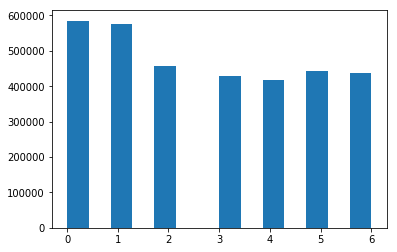

In [29]:
hist = plt.hist(train_df.order_dow, bins=14)

#### Purchase frequency by the hour of the day


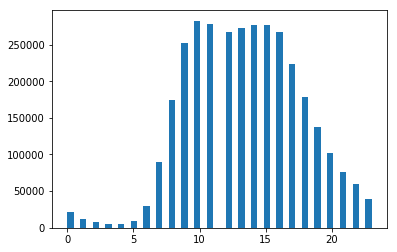

In [30]:
hist = plt.hist(train_df.order_hour_of_day, bins=48)

### Test
### Using Next Basket Prediction using Recurring Sequential Patterns approach

##### Using https://arxiv.org/pdf/1702.07158.pdf let's build a test to see how the method react over our data.

In [31]:
# Spliting into test, train and validation* 

test_df = orders.loc[orders.eval_set == 'test']
train_df = orders.loc[orders.eval_set == 'train']
prior_df = orders.loc[orders.eval_set == 'prior']

In [32]:
bc = dict()

# selecting the customer
customer = prior_df.loc[orders.user_id==1]

# getting all his orders and building a dictonary
for order in customer.order_id:
    if order in bc.keys():
        bc[order].append(order_prior.loc[order_prior.order_id==order].product_id.tolist)
    else:
        bc[order] = order_prior.loc[order_prior.order_id==order].product_id.tolist()

# getting the departments per client
department = []
    
for k,v in bc.items():
    for product in v:
        department.append(int(prod.loc[prod.product_id == product].department_id))

In [33]:
def extractTars(bc):
    S = []
    for k,v in bc.items():
        S.append(v)

(array([  5.,   0.,  13.,   0.,   0.,   0.,   4.,   0.,  15.,  22.]),
 array([  4. ,   5.5,   7. ,   8.5,  10. ,  11.5,  13. ,  14.5,  16. ,
         17.5,  19. ]),
 <a list of 10 Patch objects>)

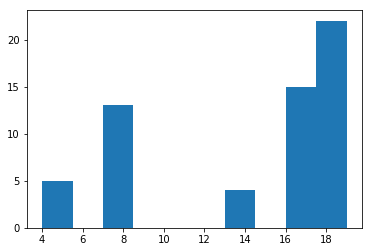

In [34]:
plt.hist(department)

## Recommendation System using a Item base approach, once we have 9 observations per-client. A content-based approach will be used to cluster and classify.

1. Data preparation: Feature selection, D-reduction, Normalizing and Subsetting
2. Data Mining: Clustering (prior) and classification (training) - OUTDATED
2.1. Data Mining: Non-negative matrix factorization and X
3. Pos-processing: Filtering and Visualization

#### Data Preparation

In [35]:
# For testing - sampling

prior_df_ = prior_df.iloc[:500,:].copy()
orders_ = orders.iloc[:500,:].copy()

In [37]:
# on the 500 entries dataset, creating a colunm with all the products for that order
product_list = dict()
qty_list = dict()

for order in prior_df_.order_id.unique():
    
    product_object = order_prior.loc[order_prior.order_id==order].product_id
    
    if order in product_list.keys():
        product_list[order].append(product_object.tolist())
        qty_list[order].append(product_object.shape[0])
    else:
        product_list[order] = product_object.tolist()
        qty_list[order] = product_object.shape[0]


# bulding the dummies from the product_list, in order to cluster over Laccart
products = pd.Series(product_list)
qtys = pd.Series(qty_list)
prod_dummies = pd.get_dummies(products.apply(pd.Series).stack()).sum(level=0)

In [38]:
# bulding the dummies from the product_list, in order to cluster over Laccart

products = pd.Series(product_list)
prod_qty_df = pd.Series(qty_list).to_frame()
prod_dummies = pd.get_dummies(products.apply(pd.Series).stack()).sum(level=0)

In [39]:
# creating index column for dataframe join; Fixing labels

prod_dummies['order_id'] = prod_dummies.index
prod_qty_df.insert(0, 'order_id', prod_qty_df.index)

prod_qty_df.columns = ['order_id', 'qty']

## Clustering + Decision Tree
##### Data Mining: User-Item Collaborative Filtering

In [40]:
# join the dummies with the prior orders

jaccard_df = prior_df_.merge(prod_dummies, right_on='order_id', left_on='order_id')

In [41]:
# running jaccard similarity

res = 1 - pdist(jaccard_df.iloc[:,7:], 'jaccard',)
distance = pd.DataFrame(squareform(res), index=jaccard_df.user_id,)

In [42]:
# MxM' getting all the similarities
distance

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.375000,0.250000,0.428571,0.181818,0.285714,0.250000,0.222222,0.222222,0.166667,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,0.375000,0.000000,0.375000,0.375000,0.400000,0.428571,0.571429,0.333333,0.333333,0.363636,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,0.250000,0.375000,0.000000,0.666667,0.444444,0.800000,0.666667,0.571429,0.571429,0.400000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,0.428571,0.375000,0.666667,0.000000,0.444444,0.800000,0.666667,0.571429,0.571429,0.400000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,0.181818,0.400000,0.444444,0.444444,0.000000,0.500000,0.444444,0.400000,0.400000,0.307692,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,0.285714,0.428571,0.800000,0.800000,0.500000,0.000000,0.800000,0.666667,0.666667,0.444444,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,0.250000,0.571429,0.666667,0.666667,0.444444,0.800000,0.000000,0.571429,0.571429,0.555556,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,0.222222,0.333333,0.571429,0.571429,0.400000,0.666667,0.571429,0.000000,1.000000,0.500000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1,0.222222,0.333333,0.571429,0.571429,0.400000,0.666667,0.571429,1.000000,0.000000,0.500000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


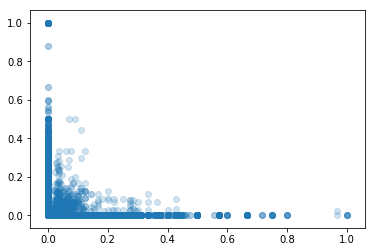

In [47]:
# Hierchical Clustering
Z = linkage(distance, 'ward')

plt.scatter(distance[:250],distance[250:], alpha=0.2)

In [48]:
Z

array([[  37.        ,   40.        ,    0.        ,    2.        ],
       [ 256.        ,  500.        ,    0.        ,    3.        ],
       [ 436.        ,  501.        ,    0.        ,    4.        ],
       ..., 
       [ 960.        ,  995.        ,    6.51689807,  431.        ],
       [ 993.        ,  996.        ,    7.89382614,  460.        ],
       [ 985.        ,  997.        ,   10.82570008,  500.        ]])

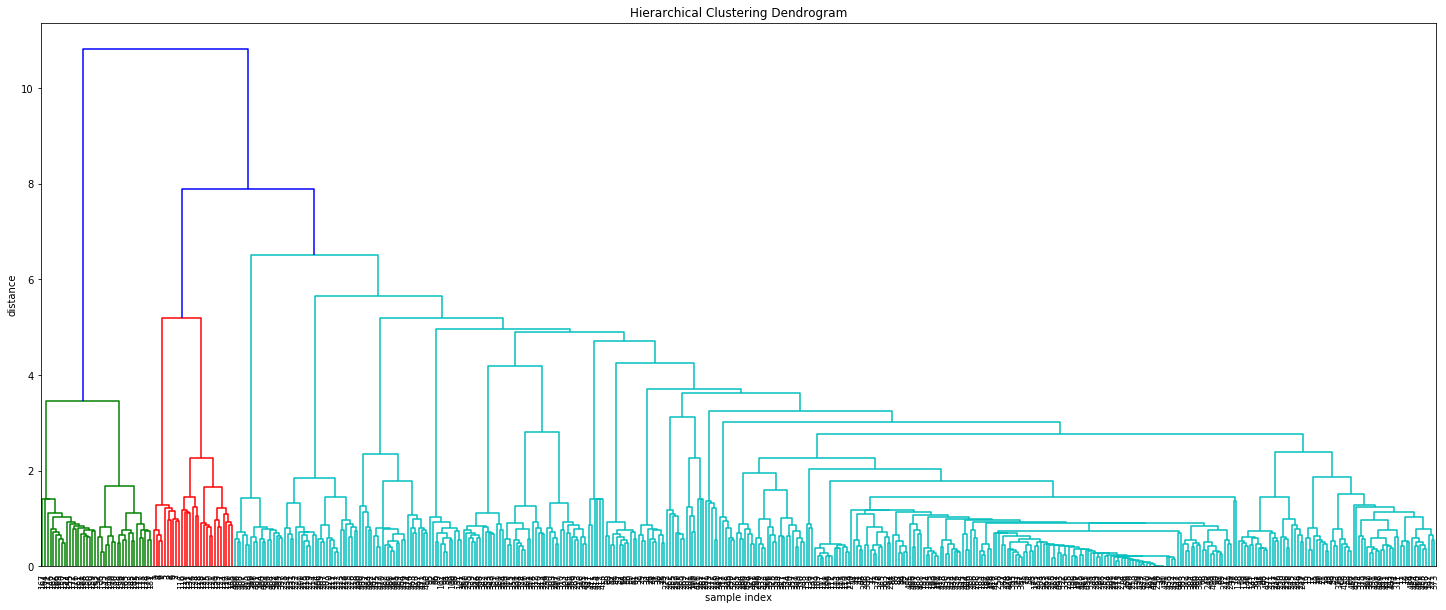

In [49]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

## Non-negative Matrix Factorization

In [50]:
# Merging product dummies with the dataset 
nnMF_df = prior_df_.merge(prod_dummies, right_on='order_id', left_on='order_id')

# Adding the amount (qty) of products per order
nnMF_df = nnMF_df.merge(prod_qty_df, right_on='order_id', left_on='order_id')

In [51]:
# Getting the total sum of each item purchase by user
nnMF_df_ = nnMF_df.iloc[:,:-1].groupby(['user_id']).sum().reset_index()

In [52]:
R = nnMF_df_.iloc[:,6:].as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [53]:
# TODO: figure out best K
U, sigma, Vt = svds(R_demeaned, k=36)

In [54]:
sigma = np.diag(sigma)

In [55]:
all_user_predicted = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted, columns = nnMF_df_.iloc[:,6:].columns)

# Adding the user ID to the predictions
preds_df.insert(0, 'user_id', nnMF_df_['user_id'])

##### Recommendation System

In [56]:
## Recommendation System
def instacart_recommender(predictions_df, userID, num_recommendations):
    
    # There is no need to check the existence of the user, once all the users already bought at least once 
    #in instacart
    
    # Get and sort the user's predictions
    user_predictions = predictions_df.loc[predictions_df.user_id == userID]
    sorted_user_predictions = user_predictions.sort_values(user_predictions.index[0], axis=1, ascending=False)
    
    items = sorted_user_predictions.columns[1:num_recommendations].tolist()
    
    # Fix printing format
    print("The user %d will buy %d items: %s"%(userID, num_recommendations, items))

    return userID, items

#### Series Regression for K items

In [57]:
# creating linear regression object
regr = linear_model.LinearRegression()

In [58]:
nnMF_df.loc[nnMF_df.user_id == 1,['qty', 'order_dow', 'order_hour_of_day']]

,qty,order_dow,order_hour_of_day
0,5,2,8
1,6,3,7
2,5,3,12
3,5,4,7
4,8,4,15
5,4,2,7
6,5,1,9
7,6,1,14
8,6,1,16
9,9,4,8


In [59]:
train_df.loc[train_df.user_id==8]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
78,880375,8,train,4,1,14,10.0


In [60]:
dow = 1
hfd = 14

# getting all the product quantities that the user bought over time 
# reshape is necessary to transform the array into 2D for linear regression
x = np.array(nnMF_df.loc[nnMF_df.user_id == 8,['order_dow', 'order_hour_of_day']])

# generating an array that will represent the time evolution 
y = np.array(nnMF_df.loc[nnMF_df.user_id == 8].qty).reshape(-1,1)

# fitting the model
fit = regr.fit(x, y)

# getting the next value to be predicted with the correct dimension
to_predict = np.array([dow, hfd])

# getting the most probably quantity of items - number of recommendations
number_recommendations = fit.predict(to_predict)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [68]:
# Testing on prediction - TODO: Implement prediction Method to reduce std error!

In [61]:
fit.coef_ #DOW, HOTD

array([[ 8.  ,  4.25]])

In [62]:
int(number_recommendations[0][0])

40

In [64]:
x = int(train_df.loc[train_df.user_id==5].order_id)

In [ ]:
predicted

In [ ]:
real_values

In [66]:
# Getting the number of items each client will buy
def products_qty(qty_df, userID):

    # Getting the quantities per user
    X = qty[['user_id', 'qty']].loc[qty.user_id == 1].qty
    
    regr.fit(diabetes_X_train, diabetes_y_train)

In [67]:
# Testing

#for user in test_df.user_id.tolist():
    # get number of recommendations
    #instacart_recommender(preds_df, 1, 5)

#### Post processing

In [ ]:
#TODO: Cross validation for K value, Improve the N items prediction, transform the regression into a method